In [10]:
# Suppress warnings
import warnings 
warnings.simplefilter('ignore')

import pyrcel as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.animation as animation

In [11]:
def run_default_parcel(h):
    # environmental variables
    P0 = 1e5 # Initial Pressure, Pa
    T0 = 280.   # Initial Temperature, K
    S0 = -0.15  # Initial Supersaturation, 1-RH (85% here)

    # regime-determining variables
    w = 6.0 # updraft velocity (m/s)
    N = w*2.0e3 # total particle number

    # initial lognormal distribution variables
    # shared variables
    sig = 1.5 # geometric standard deviation
    bins = 200 # number of bins to track (maybe choose this in relation to sigma)
    
    name1 = 'default'
    mu1 = 0.1
    kappa1 = 0.5
    aer1 = pm.AerosolSpecies(name1, pm.Lognorm(mu=mu1, sigma=sig, N=N), kappa=kappa1, bins=bins)
    initial_aerosols = [aer1]

    dt = 1.0 # timestep (s)
    h_end = h # end altitude (m)
    t_end = h_end/w # end time (s)

    model = pm.ParcelModel(initial_aerosols, w, T0, S0, P0, console=False, accom=0.5)
    parcel_trace, aerosol_traces = model.run(t_end, dt, solver='cvode')

    return(initial_aerosols, parcel_trace, aerosol_traces)

In [15]:
def make_anim(parcel_trace, aerosol_trace, init_aer, name):
    T = parcel_trace["T"].values
    z = parcel_trace["z"].values
    N = init_aer.Nis
    r = aerosol_trace.values
    frames = np.shape(z)[0]

    # initialize figure and axes
    fig = plt.figure(figsize=(10,6))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1,4]) 
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    
    # initialize parcel profile plot
    Tprof, = ax1.plot(T[0:1],z[0:1],'ro-')
    ax1.grid(True, linestyle = '-', color = '0.5')
    ax1.set_xlim([np.min(T), np.max(T)])
    ax1.set_ylim([np.min(z), np.max(z)])
    ax1.set_xlabel("Temp. (K)")
    ax1.set_ylabel("Alt. (m)")
    
    # initialize aerosol distribution plot
    maxN = np.max(N)
    dist, = ax2.semilogx(r[0,:], N/maxN, 'bo-')
    ax2.grid(True, linestyle = '-', color = '0.55')
    ax2.set_xlim([np.min(r), np.max(r)])
    ax2.set_ylim([0,1])
    ax2.set_xlabel("Droplet radius ($\mu$m)")
    ax2.set_ylabel("Number")
    ax2.yaxis.tick_right()

    def _update_plot(i):
        # update parcel plot
        Tprof.set_xdata(T[0:i+1])
        Tprof.set_ydata(z[0:i+1])
        # update aerosol distribution plot
        dist.set_xdata(r[i,:])
        dist.set_ydata(N/maxN)
        # return
        return Tprof, dist,

    # Set up formatting for the movie files
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=30)

    anim = animation.FuncAnimation(fig, _update_plot, frames=frames)
    anim.save("anims/parcel_evolution_"+name+".mp4", writer=writer, dpi=300)

In [13]:
h = 2e3
initial_aerosols, parcel_trace, aerosol_traces = run_default_parcel(h)

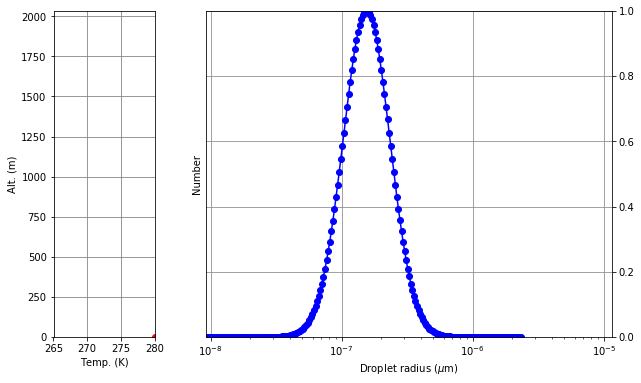

In [16]:
#for i,key in enumerate(aerosol_traces.keys()):
i = 0
key = "default"
init_aer = initial_aerosols[i]
aerosol_trace = aerosol_traces[key]
make_anim(parcel_trace, aerosol_trace, init_aer, key)

In [ ]:
def _update_plot(i, fig, scat):
    scat.set_offsets(([0, i], [50, i], [100, i]))
    #print('Frames: {}'.format(i)) # For Python3
    return scat

# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

fig = plt.figure()

x = [0, 50, 100]
y = [0, 0, 0]

ax = fig.add_subplot(111)
ax.grid(True, linestyle = '-', color = '0.75')
ax.set_xlim([-50, 200])
ax.set_ylim([-50, 200])

scat = plt.scatter(x, y, c='r', marker='o')
scat.set_alpha(0.8)

anim = animation.FuncAnimation(fig, _update_plot, fargs = (fig, scat), frames = 100, interval = 100)
anim.save('anims/anim_scat.mp4', writer=writer, dpi=300)

In [ ]:
fig, ax = plt.subplots()

x = np.arange(0, 2*np.pi, 0.01)
y = np.sin(x)
line, = ax.plot(x, y)

def init():  # only required for blitting to give a clean slate.
    line.set_ydata([np.nan] * len(x))
    return line,

def _update_plot(i):
    #line.set_ydata(np.sin(x + i / 100))  # update the data.
    line.set_xdata(x+i/100)
    line.set_ydata(y)
    return line,

# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

anim = animation.FuncAnimation(fig, _update_plot, init_func=init, interval=2, blit=True, save_count=50)
anim.save("anims/anim_line.mp4", writer=writer, dpi=300)

In [ ]:
fig = plt.figure(figsize=(10,6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1,4]) 
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

frames = 100

T = 300 - np.arange(frames+1)
z = np.arange(frames+1)

Tprof, = ax1.plot(T[0:1],z[0:1],'ro-')
ax1.grid(True, linestyle = '-', color = '0.5')
ax1.set_xlim([np.min(T), np.max(T)])
ax1.set_ylim([np.min(z), np.max(z)])
ax1.set_xlabel("Temp. (K)")
ax1.set_ylabel("Alt. (m)")

r = np.zeros((frames,100))
for i in np.arange(frames):
    r[i,:] = np.linspace(i/100,2*np.pi+i/100,100)
N = np.sin(r[0,:])
dist, = ax2.plot(r[0,:], N, 'bo-')
ax2.grid(True, linestyle = '-', color = '0.55')
ax2.set_xlim([np.min(r), np.max(r)])
ax2.set_ylim([np.min(N), np.max(N)])
ax2.set_xlabel("Droplet radius ($\mu$m)")
ax2.set_ylabel("Number")
ax2.yaxis.tick_right()

def _update_plot(i):
    Tprof.set_xdata(T[0:i+1])
    Tprof.set_ydata(z[0:i+1])
    
    dist.set_xdata(r[i,:])
    dist.set_ydata(N)
    
    return prof, dist,

# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=10, metadata=dict(artist='Clare Singer'), bitrate=1800)

anim = animation.FuncAnimation(fig, _update_plot, frames=frames, interval=100)
anim.save("anims/anim_two_panel.mp4", writer=writer, dpi=300)